<a href="https://colab.research.google.com/github/ikhsanmn/brain_tumor_detection_machine_learning/blob/main/project_ai_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

from google.colab import files: Allows you to upload/download files in Google Colab.

import os: Imports the os module to interact with the file system (e.g., paths, directories).

In [ ]:
from google.colab import files
import os



In [ ]:
dataset_path = "./kaggle/input/brain-tumor-dataset"
train_dir = os.path.join(dataset_path, "Training") # os.path.join is used to generate a path connecting "dataset_path" and the string "Training".
test_dir = os.path.join(dataset_path, "Testing") # os.path.join を用いて、dataset_path と 文字列 Testing をつなげたパスを生成しています。

dataset_path: The location of the dataset on your Colab environment.

train_dir: Builds the path to the training data folder using os.path.join.

test_dir: Builds the path to the testing data folder.

This block prepares the file paths for training and testing datasets.

In [ ]:
!pip install kaggle
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download masoudnickparvar/brain-tumor-mri-dataset


Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 75 bytes
Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 51% 76.0M/149M [00:00<00:00, 796MB/s]
100% 149M/149M [00:00<00:00, 717MB/s] 


Installs the Kaggle API.

Allows user to upload their kaggle.json (Kaggle API credentials).

Moves the file to the correct location (~/.kaggle/) and sets proper permissions.

Downloads the brain tumor MRI dataset from Kaggle.

In [ ]:
!unzip brain-tumor-mri-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

In [ ]:
!rm -rf ./content/kaggle/input/brain-tumor-dataset/Testing

In [ ]:
!mkdir -p ./content/kaggle/input/brain-tumor-dataset
!mv Testing ./content/kaggle/input/brain-tumor-dataset
!mv Training ./content/kaggle/input/brain-tumor-dataset


Ensures the directory structure for training and testing datasets is properly recreated.

Moves Training and Testing folders into the expected dataset path.

In [ ]:
!cp -r ./content/kaggle/input/brain-tumor-dataset/Training/glioma/* ./content/kaggle/input/brain-tumor-dataset/Training/alldata/
!cp -r ./content/kaggle/input/brain-tumor-dataset/Training/meningioma//* ./content/kaggle/input/brain-tumor-dataset/Training/alldata/
!cp -r ./content/kaggle/input/brain-tumor-dataset/Training/notumor/* ./content/kaggle/input/brain-tumor-dataset/Training/alldata/
!cp -r ./content/kaggle/input/brain-tumor-dataset/Training/pituitary/* ./content/kaggle/input/brain-tumor-dataset/Training/alldata/


cp: target './content/kaggle/input/brain-tumor-dataset/Training/alldata/' is not a directory
cp: target './content/kaggle/input/brain-tumor-dataset/Training/alldata/' is not a directory
cp: target './content/kaggle/input/brain-tumor-dataset/Training/alldata/' is not a directory
cp: target './content/kaggle/input/brain-tumor-dataset/Training/alldata/' is not a directory


Copies all images from each tumor category (glioma, meningioma, notumor, pituitary) into a single directory: alldata.

This could be for preprocessing, model training, or performing operations across the entire training dataset.

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.applications import DenseNet121, ResNet50, InceptionV3
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_densenet
from tensorflow.keras.applications.resnet import preprocess_input as preprocess_resnet
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_inception
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Path dataset dan CSV output
dataset_path2 = './content/kaggle/input/brain-tumor-dataset/Training/'  # Folder berisi gambar
output_csv_path = '/content/kaggle/input/brain-tumor-dataset/Training/featurecsv/features_AIlanjut'  # Prefix untuk nama file CSV

target_names = [
    'glioma', 'meningioma', 'notumor',
    'pituitary'
]

# Fungsi untuk memuat model tanpa layer klasifikasi (hanya fitur fc1000)
def load_model_without_classification(base_model, preprocess_fn):
    base_model.trainable = False
    model = tf.keras.Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)
    return model, preprocess_fn

# Memuat model DenseNet, ResNet, dan Inception
models = {
    "DenseNet": load_model_without_classification(DenseNet121(weights='imagenet'), preprocess_densenet),
    "ResNet": load_model_without_classification(ResNet50(weights='imagenet'), preprocess_resnet),
    "InceptionV3": load_model_without_classification(InceptionV3(weights='imagenet'), preprocess_inception)
}

# Fungsi untuk memproses gambar dan mengekstrak fitur
def extract_features(model, preprocess_fn, image_path, target_size):
    image = load_img(image_path, target_size=target_size)
    image_array = img_to_array(image)
    image_array = np.expand_dims(image_array, axis=0)
    image_array = preprocess_fn(image_array)
    features = model.predict(image_array)
    return features.flatten()

In [ ]:
import os

# Menyimpan fitur ke CSV
for model_name, (model, preprocess_fn) in models.items():
    print(f"Extracting features using {model_name}...")
    all_features = []
    labels = []

    for label in target_names:
        folder_path = os.path.join(dataset_path2, label)
        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)
            features = extract_features(model, preprocess_fn, image_path, (224, 224) if model_name != "InceptionV3" else (299, 299))
            all_features.append(features)
            labels.append(label)

    # Simpan ke CSV
    feature_df = pd.DataFrame(all_features)
    feature_df['Label'] = labels
    csv_file = f"{output_csv_path}{model_name}.csv"

    # Create the directory if it doesn't exist
    os.makedirs(os.path.dirname(csv_file), exist_ok=True)

    feature_df.to_csv(csv_file, index=False)
    print(f"Features saved to {csv_file}.")

Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━

extracting features and save to csv file

For each model:

Loops through each class and each image.

Extracts features and labels.

Saves the features and labels as a CSV file.

CSV files will later be used for training a classifier (e.g. SVM, RandomForest).



In [ ]:
from tensorflow.keras.applications import DenseNet121, ResNet50, InceptionV3

# Memuat model pre-trained
densenet_model = DenseNet121(weights='imagenet')
resnet_model = ResNet50(weights='imagenet')
inception_model = InceptionV3(weights='imagenet')

# Menampilkan summary dari setiap model
print("DenseNet121 Summary:")
densenet_model.summary()

print("\nResNet50 Summary:")
resnet_model.summary()

print("\nInceptionV3 Summary:")
inception_model.summary()


DenseNet121 Summary:


Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_4    │ (None, 230, 230,  │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_4… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_5    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_5… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 8,062,504 (30.76 MB)

 Trainable params: 7,978,856 (30.44 MB)

 Non-trainable params: 83,648 (326.75 KB)


ResNet50 Summary:


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_7[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)


InceptionV3 Summary:


Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_188 (Conv2D) │ (None, 149, 149,  │        864 │ input_layer_8[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 149, 149,  │         96 │ conv2d_188[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_188      │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_189 (Conv2D) │ (None, 147, 147,  │      9,216 │ activation_188[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_189[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_189      │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_190 (Conv2D) │ (None, 147, 147,  │     18,432 │ activation_189[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_190[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_190      │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 73, 73,    │          0 │ activation_190[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_191 (Conv2D) │ (None, 73, 73,    │      5,120 │ max_pooling2d_8[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_191[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_191      │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_192 (Conv2D) │ (None, 71, 71,    │    138,240 │ activation_191[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_192[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_192      │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 23,851,784 (90.99 MB)

 Trainable params: 23,817,352 (90.86 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [ ]:
import pandas as pd

In [ ]:
df_densenet = pd.read_csv('/content/kaggle/input/brain-tumor-dataset/Training/featurecsv/features_AIlanjutDenseNet.csv')
df_inception = pd.read_csv('/content/kaggle/input/brain-tumor-dataset/Training/featurecsv/features_AIlanjutInceptionV3.csv')
df_resnet = pd.read_csv('/content/kaggle/input/brain-tumor-dataset/Training/featurecsv/features_AIlanjutResNet.csv')


In [ ]:
df_densenet

0         1         2         3         4         5         6  \
0     0.000478  0.005291  0.000100  0.004330  0.102144  0.127863  0.000715   
1     0.000659  0.006945  0.002186  0.003753  0.090303  0.167790  0.000917   
2     0.000497  0.005049  0.000221  0.004303  0.090461  0.134306  0.000811   
3     0.000573  0.006746  0.000209  0.004123  0.131224  0.171006  0.000711   
4     0.000523  0.007694  0.000651  0.003661  0.128913  0.108400  0.000822   
...        ...       ...       ...       ...       ...       ...       ...   
5707  0.000455  0.008943  0.001462  0.003231  0.057379  0.157192  0.000634   
5708  0.000839  0.008367  0.001490  0.002992  0.146278  0.209038  0.000515   
5709  0.000399  0.007015  0.000908  0.003056  0.082393  0.177298  0.000685   
5710  0.000702  0.006521  0.002043  0.004055  0.058506  0.259870  0.000646   
5711  0.000451  0.005955  0.000684  0.002324  0.096592  0.195432  0.000297   

             7         8         9  ...      1015      1016      1017  \
0     0.002416  0.201178  0.000308  ...  0.139619  0.538049  1.040994   
1     0.002598  0.260822  0.000500  ...  0.506202  0.219932  0.995830   
2     0.002624  0.222758  0.000303  ...  0.160354  0.863230  1.807579   
3     0.002829  0.202285  0.000426  ...  0.961749  0.420368  0.945502   
4     0.002272  0.267056  0.000341  ...  0.257668  0.364863  0.760096   
...        ...       ...       ...  ...       ...       ...       ...   
5707  0.002112  0.172390  0.000400  ...  0.058375  0.693872  1.548204   
5708  0.002312  0.265761  0.000447  ...  0.221585  0.254531  0.545810   
5709  0.003245  0.334650  0.000536  ...  0.566197  0.217535  1.100483   
5710  0.002413  0.241769  0.000539  ...  0.896540  0.435234  1.075521   
5711  0.002851  0.258423  0.000418  ...  0.199944  0.432885  1.046084   

          1018      1019      1020      1021      1022      1023      Label  
0     0.614002  0.218291  0.000000  0.755439  0.122960  0.438429     glioma  
1     0.677657  0.824079  0.332972  0.919148  0.166663  0.423763     glioma  
2     1.288176  0.196949  0.000000  0.984179  0.111509  0.140409     glioma  
3     0.500596  0.006459  0.042914  1.294967  0.079974  0.290312     glioma  
4     0.239075  0.139457  0.013925  1.130307  0.053253  0.629600     glioma  
...        ...       ...       ...       ...       ...       ...        ...  
5707  0.210400  0.281527  0.000000  2.485463  0.271104  0.211523  pituitary  
5708  2.107209  0.008086  0.231117  2.336873  0.309008  0.295424  pituitary  
5709  0.125575  0.096210  0.070104  0.817950  0.213316  0.200096  pituitary  
5710  2.615677  0.179664  0.264116  2.574981  0.195540  0.570675  pituitary  
5711  0.295288  0.410028  0.000000  1.197977  0.646463  0.044299  pituitary  

[5712 rows x 1025 columns]

In [ ]:
df_inception

0         1         2         3         4         5         6  \
0     0.800612  0.136056  0.277050  0.002227  0.027733  0.187350  0.894059   
1     0.812476  0.011892  0.224033  0.242336  0.119383  0.718181  0.637374   
2     0.226113  0.504350  0.138245  0.273592  0.008041  0.106538  0.265656   
3     0.537078  0.145506  0.390809  0.048763  0.017230  0.262501  0.279306   
4     0.413699  0.000000  0.105375  0.369940  0.125446  0.522916  0.153858   
...        ...       ...       ...       ...       ...       ...       ...   
5707  0.431897  0.450220  0.369869  0.261714  0.177500  0.602793  0.364961   
5708  0.482785  0.278315  0.235917  0.458432  0.021008  0.309121  0.129571   
5709  0.331986  0.147112  0.117523  0.194846  0.078245  0.227347  0.152876   
5710  0.606911  0.231172  0.232918  0.309037  0.106928  0.152733  0.102699   
5711  0.682189  0.014114  0.581284  0.296665  0.109336  0.669610  0.206922   

             7         8         9  ...      2039      2040      2041  \
0     0.321952  0.008159  0.013897  ...  0.037481  0.588336  0.183392   
1     0.414482  0.012191  0.043831  ...  0.156689  0.608091  0.720190   
2     0.186777  0.144289  0.109625  ...  0.058505  0.625448  0.228766   
3     0.200509  0.016909  0.038110  ...  0.000926  0.696796  0.548101   
4     0.511423  0.138102  0.147661  ...  0.030795  1.297979  0.771565   
...        ...       ...       ...  ...       ...       ...       ...   
5707  0.494973  0.125607  0.227032  ...  0.916132  1.164203  0.112355   
5708  0.222280  0.186726  0.183931  ...  1.115107  2.168259  0.082096   
5709  0.115546  0.174211  0.150629  ...  0.077786  0.825464  0.263378   
5710  0.431789  0.135521  0.341089  ...  0.930709  2.134487  0.131812   
5711  0.327341  0.046634  0.003660  ...  0.329116  1.831797  0.593058   

          2042      2043      2044      2045      2046      2047      Label  
0     0.029802  0.060984  0.452087  0.511184  0.460581  0.050574     glioma  
1     0.271295  0.000987  0.250842  0.712869  0.262419  0.276738     glioma  
2     0.113601  0.120737  0.171964  0.434331  0.697576  1.035350     glioma  
3     0.010611  0.084641  0.282977  0.801690  0.733329  0.257644     glioma  
4     0.037826  0.020187  0.166676  0.128103  0.520615  0.161033     glioma  
...        ...       ...       ...       ...       ...       ...        ...  
5707  0.563099  0.008588  0.507558  0.360465  0.072616  0.809482  pituitary  
5708  0.040073  0.019350  0.421968  1.271635  0.473884  0.551442  pituitary  
5709  0.242586  0.000421  0.659859  1.039805  0.877288  0.568723  pituitary  
5710  0.177982  0.047995  0.808311  0.920086  0.586591  0.778221  pituitary  
5711  0.124706  0.033206  0.323274  0.086973  1.155959  0.624926  pituitary  

[5712 rows x 2049 columns]

In [ ]:
df_resnet

0         1         2         3         4         5         6  \
0     0.000000  0.115265  0.000000  0.008397  0.590517  0.000000  1.037440   
1     0.543918  0.926579  0.076783  0.893842  1.949418  0.016288  0.840520   
2     0.829040  0.155474  0.041982  0.584506  1.740679  0.054468  3.448208   
3     0.231534  0.628636  0.019471  0.105870  0.680350  0.289573  1.977566   
4     0.469619  2.136427  0.000000  0.695148  1.448022  0.000000  1.641906   
...        ...       ...       ...       ...       ...       ...       ...   
5707  0.015876  1.749751  0.357182  0.777171  0.066579  0.232753  2.728223   
5708  0.236511  2.102117  0.002518  0.279499  0.879805  0.090055  0.202918   
5709  0.053363  1.436984  0.009175  0.765376  0.115184  0.098935  1.827279   
5710  0.151127  0.732598  0.028789  0.636120  0.878891  0.097002  1.405185   
5711  0.327476  1.329108  0.000000  1.038450  1.556982  0.511068  2.094688   

             7         8         9  ...      2039      2040      2041  \
0     0.000000  0.013749  0.000000  ...  0.000000  0.050521  0.309433   
1     0.000000  0.386930  0.028403  ...  0.000000  0.046951  0.508501   
2     0.002077  0.111446  0.000000  ...  0.452155  0.103389  0.103881   
3     0.000000  0.002017  0.000000  ...  0.000000  0.027579  0.085935   
4     0.000000  0.353605  0.032741  ...  0.000000  0.000000  0.182396   
...        ...       ...       ...  ...       ...       ...       ...   
5707  0.222214  0.087039  0.000000  ...  0.000000  0.086345  0.184795   
5708  0.309759  0.309696  0.051979  ...  0.052128  0.338356  0.113620   
5709  0.020538  0.155346  0.000000  ...  0.008232  0.000519  0.049059   
5710  0.032101  0.077342  0.000000  ...  0.039377  0.425373  0.213674   
5711  0.033993  0.165095  0.000000  ...  0.000000  0.489476  0.027320   

          2042      2043      2044      2045      2046      2047      Label  
0     0.014243  0.000000  0.114402  0.513396  2.191637  0.366969     glioma  
1     0.121491  0.755786  0.084760  0.066718  4.032449  0.056682     glioma  
2     0.000000  1.382382  0.181077  0.008404  3.430048  1.131542     glioma  
3     0.918531  0.000000  0.000000  0.004804  1.727048  0.059349     glioma  
4     0.087649  0.213647  0.000000  0.013331  2.174926  0.229458     glioma  
...        ...       ...       ...       ...       ...       ...        ...  
5707  0.247490  1.460529  0.039861  0.000000  0.826380  0.283627  pituitary  
5708  0.643717  1.318386  0.001553  0.010239  3.635353  0.040003  pituitary  
5709  0.031457  0.540771  0.000000  0.097734  2.479690  0.023391  pituitary  
5710  0.567574  0.988529  0.004815  0.009173  1.975134  0.023202  pituitary  
5711  0.410393  0.651742  0.000000  0.105668  2.541629  0.092963  pituitary  

[5712 rows x 2049 columns]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [ ]:
# Encode label untuk setiap dataset
def encode_labels(df):
    label_encoder = LabelEncoder()
    df['EncodedLabel'] = label_encoder.fit_transform(df['Label'])
    return df, label_encoder

# Encode DenseNet
df_densenet, le_densenet = encode_labels(df_densenet)
# Encode InceptionV3
df_inception, le_inception = encode_labels(df_inception)
# Encode ResNet
df_resnet, le_resnet = encode_labels(df_resnet)


In [ ]:
def split_data(df):
    X = df.drop(columns=['Label', 'EncodedLabel'])  # Fitur
    y = df['EncodedLabel']  # Label
    return train_test_split(X, y, test_size=0.2, random_state=42)

# DenseNet
X_train_densenet, X_test_densenet, y_train_densenet, y_test_densenet = split_data(df_densenet)
# InceptionV3
X_train_inception, X_test_inception, y_train_inception, y_test_inception = split_data(df_inception)
# ResNet
X_train_resnet, X_test_resnet, y_train_resnet, y_test_resnet = split_data(df_resnet)


DenseNet:
Training SVM with kernel: rbf
              precision    recall  f1-score   support

           0       0.98      0.84      0.90       288
           1       0.80      0.83      0.82       265
           2       0.94      0.98      0.96       291
           3       0.93      0.98      0.95       299

    accuracy                           0.91      1143
   macro avg       0.91      0.91      0.91      1143
weighted avg       0.91      0.91      0.91      1143



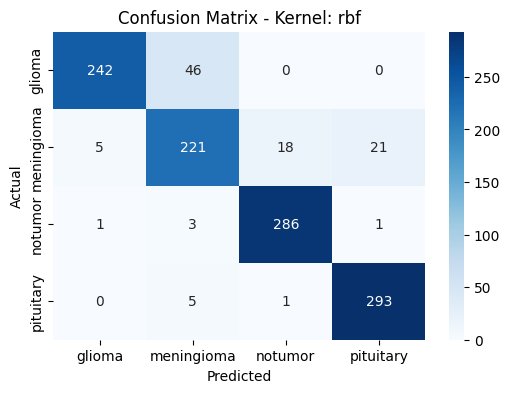

Computation Time: 12.88 seconds

Training SVM with kernel: linear
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       288
           1       0.88      0.83      0.85       265
           2       0.95      0.98      0.96       291
           3       0.94      0.97      0.96       299

    accuracy                           0.93      1143
   macro avg       0.93      0.93      0.93      1143
weighted avg       0.93      0.93      0.93      1143



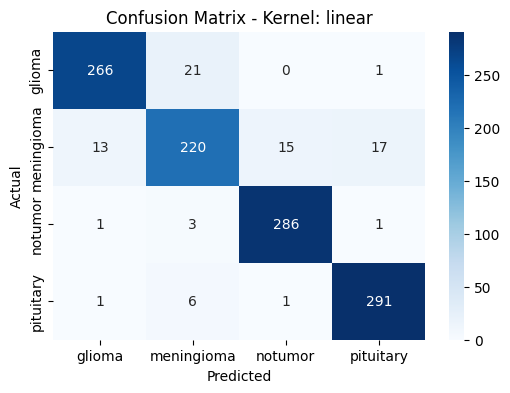

Computation Time: 3.91 seconds

Training SVM with kernel: poly
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       288
           1       0.86      0.85      0.86       265
           2       0.94      0.98      0.96       291
           3       0.94      0.98      0.96       299

    accuracy                           0.93      1143
   macro avg       0.93      0.93      0.93      1143
weighted avg       0.93      0.93      0.93      1143



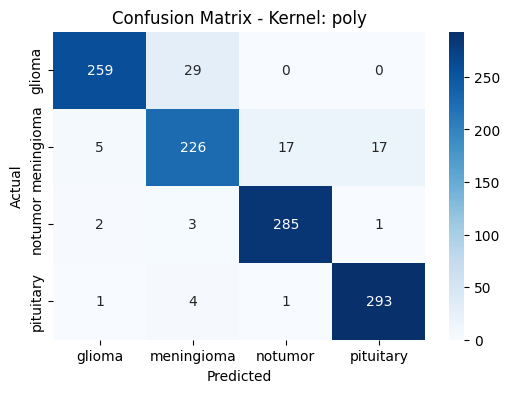

Computation Time: 7.53 seconds


InceptionV3:
Training SVM with kernel: rbf
              precision    recall  f1-score   support

           0       0.98      0.85      0.91       288
           1       0.82      0.86      0.84       265
           2       0.93      0.99      0.96       291
           3       0.94      0.96      0.95       299

    accuracy                           0.92      1143
   macro avg       0.92      0.92      0.92      1143
weighted avg       0.92      0.92      0.92      1143



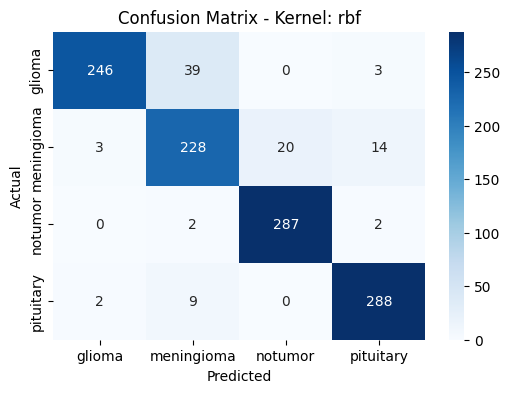

Computation Time: 20.87 seconds

Training SVM with kernel: linear
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       288
           1       0.86      0.87      0.87       265
           2       0.94      0.98      0.96       291
           3       0.97      0.96      0.97       299

    accuracy                           0.93      1143
   macro avg       0.93      0.93      0.93      1143
weighted avg       0.93      0.93      0.93      1143



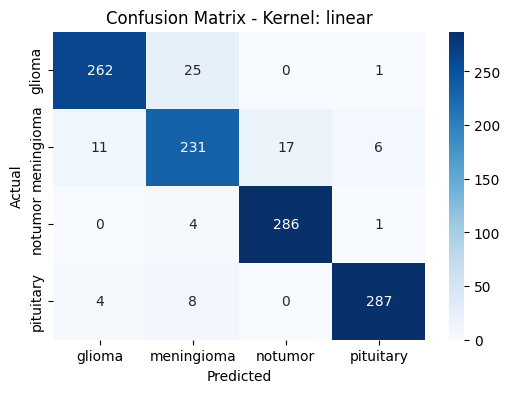

Computation Time: 10.64 seconds

Training SVM with kernel: poly
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       288
           1       0.90      0.91      0.90       265
           2       0.96      0.99      0.97       291
           3       0.96      0.97      0.96       299

    accuracy                           0.95      1143
   macro avg       0.95      0.95      0.95      1143
weighted avg       0.95      0.95      0.95      1143



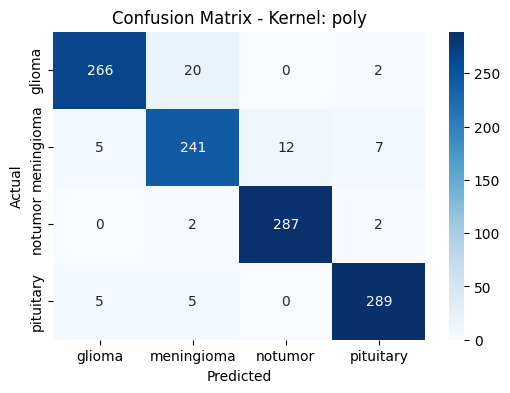

Computation Time: 12.89 seconds


ResNet:
Training SVM with kernel: rbf
              precision    recall  f1-score   support

           0       0.99      0.87      0.93       288
           1       0.83      0.86      0.85       265
           2       0.94      0.99      0.96       291
           3       0.94      0.96      0.95       299

    accuracy                           0.92      1143
   macro avg       0.92      0.92      0.92      1143
weighted avg       0.93      0.92      0.92      1143



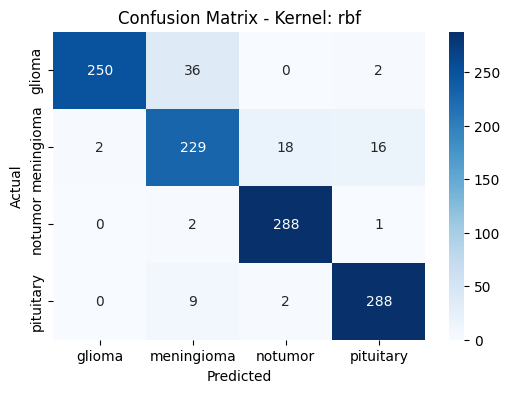

Computation Time: 17.01 seconds

Training SVM with kernel: linear
              precision    recall  f1-score   support

           0       0.97      0.92      0.94       288
           1       0.89      0.89      0.89       265
           2       0.94      0.99      0.96       291
           3       0.98      0.98      0.98       299

    accuracy                           0.95      1143
   macro avg       0.94      0.94      0.94      1143
weighted avg       0.95      0.95      0.95      1143



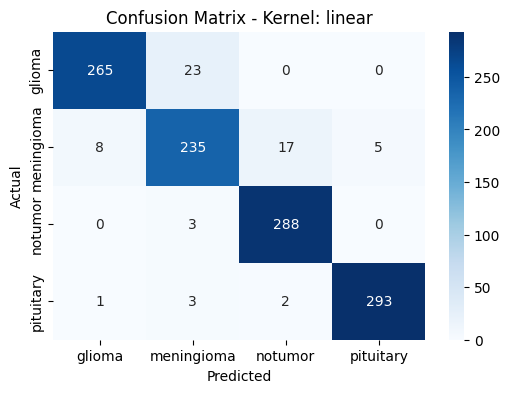

Computation Time: 8.89 seconds

Training SVM with kernel: poly
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       288
           1       0.86      0.89      0.88       265
           2       0.94      0.99      0.97       291
           3       0.97      0.97      0.97       299

    accuracy                           0.94      1143
   macro avg       0.94      0.94      0.94      1143
weighted avg       0.94      0.94      0.94      1143



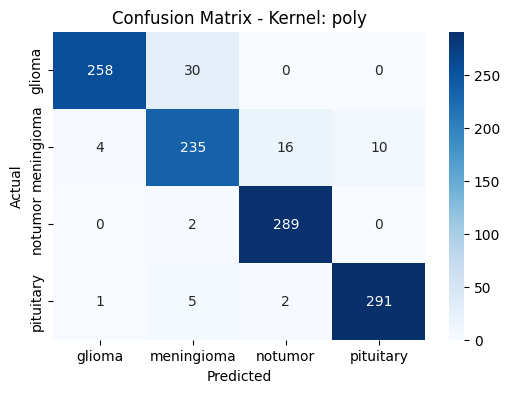

Computation Time: 11.79 seconds



SVC(kernel='poly', random_state=42)

In [ ]:
def train_and_evaluate_svm(X_train, X_test, y_train, y_test, kernel):
    print(f"Training SVM with kernel: {kernel}")
    start_time = time.time()
    model = SVC(kernel=kernel, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    end_time = time.time()

    # Classification Report
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    class_name = ['glioma','meningioma','notumor','pituitary']
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_name , yticklabels=class_name)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - Kernel: {kernel}')
    plt.show()

    # Computation Time
    print(f"Computation Time: {end_time - start_time:.2f} seconds\n")

    return model

# DenseNet
print("DenseNet:")
train_and_evaluate_svm(X_train_densenet, X_test_densenet, y_train_densenet, y_test_densenet, kernel='rbf')
train_and_evaluate_svm(X_train_densenet, X_test_densenet, y_train_densenet, y_test_densenet, kernel='linear')
train_and_evaluate_svm(X_train_densenet, X_test_densenet, y_train_densenet, y_test_densenet, kernel='poly')

# InceptionV3
print("\nInceptionV3:")
train_and_evaluate_svm(X_train_inception, X_test_inception, y_train_inception, y_test_inception, kernel='rbf')
train_and_evaluate_svm(X_train_inception, X_test_inception, y_train_inception, y_test_inception, kernel='linear')
train_and_evaluate_svm(X_train_inception, X_test_inception, y_train_inception, y_test_inception, kernel='poly')

# ResNet
print("\nResNet:")
train_and_evaluate_svm(X_train_resnet, X_test_resnet, y_train_resnet, y_test_resnet, kernel='rbf')
train_and_evaluate_svm(X_train_resnet, X_test_resnet, y_train_resnet, y_test_resnet, kernel='linear')
train_and_evaluate_svm(X_train_resnet, X_test_resnet, y_train_resnet, y_test_resnet, kernel='poly')


DenseNet:
Training SVM with kernel: rbf

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.84      0.90       288
           1       0.80      0.83      0.82       265
           2       0.94      0.98      0.96       291
           3       0.93      0.98      0.95       299

    accuracy                           0.91      1143
   macro avg       0.91      0.91      0.91      1143
weighted avg       0.91      0.91      0.91      1143



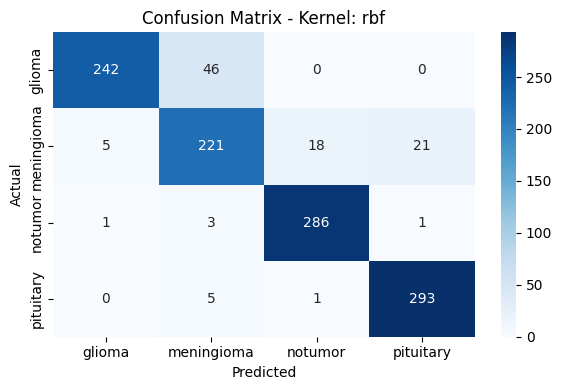

Computation Time: 14.09 seconds



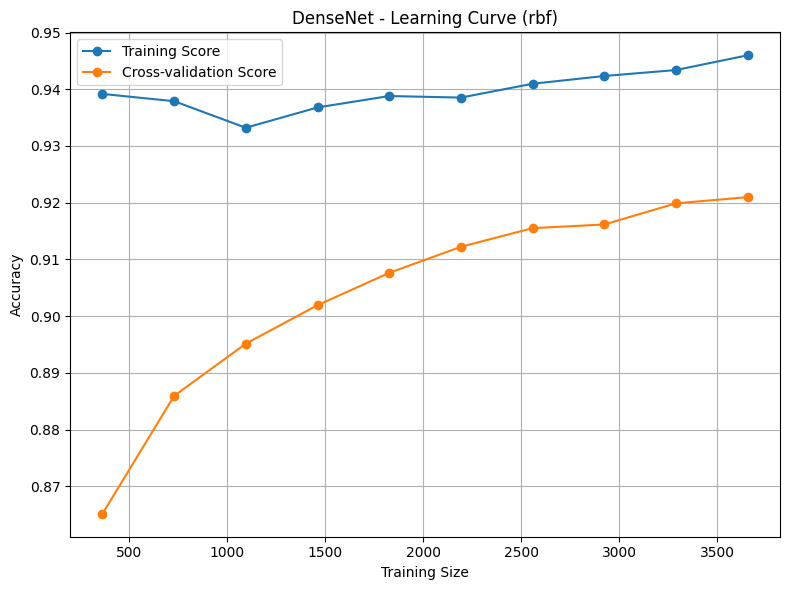

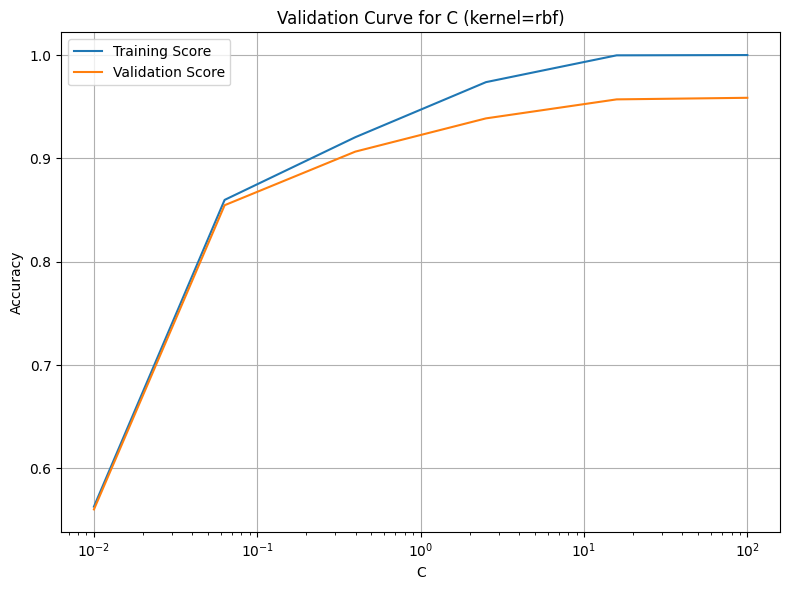

Training SVM with kernel: linear

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       288
           1       0.88      0.83      0.85       265
           2       0.95      0.98      0.96       291
           3       0.94      0.97      0.96       299

    accuracy                           0.93      1143
   macro avg       0.93      0.93      0.93      1143
weighted avg       0.93      0.93      0.93      1143



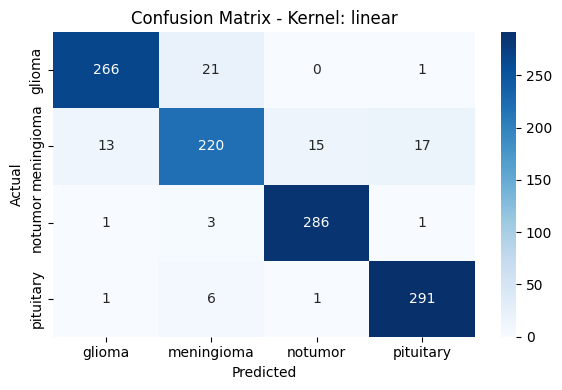

Computation Time: 4.05 seconds



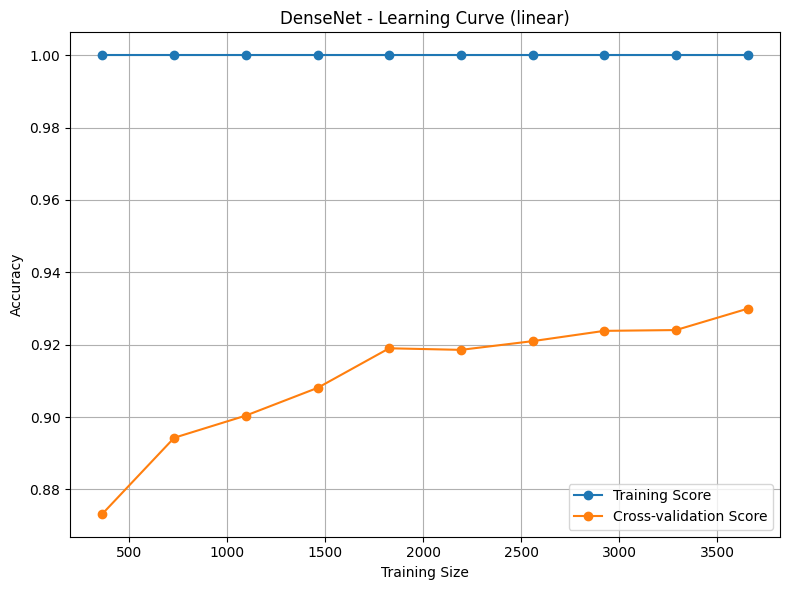

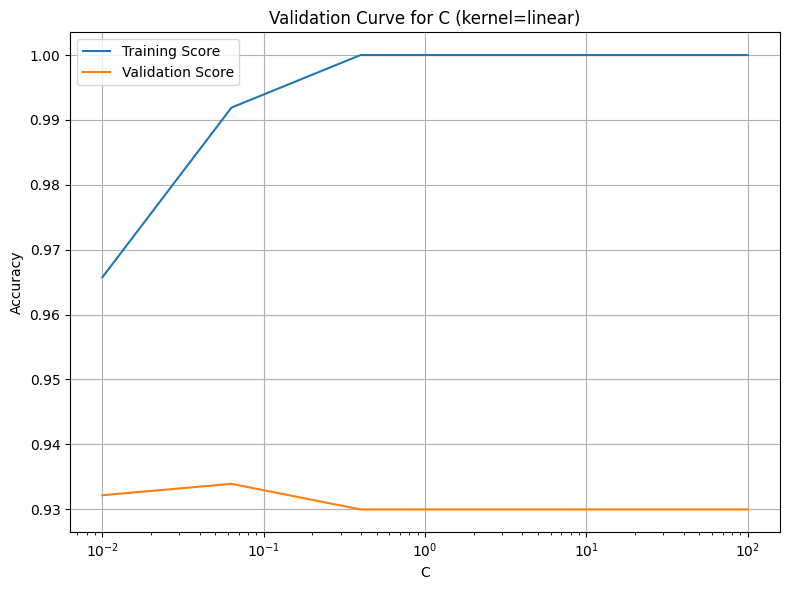

Training SVM with kernel: poly

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       288
           1       0.86      0.85      0.86       265
           2       0.94      0.98      0.96       291
           3       0.94      0.98      0.96       299

    accuracy                           0.93      1143
   macro avg       0.93      0.93      0.93      1143
weighted avg       0.93      0.93      0.93      1143



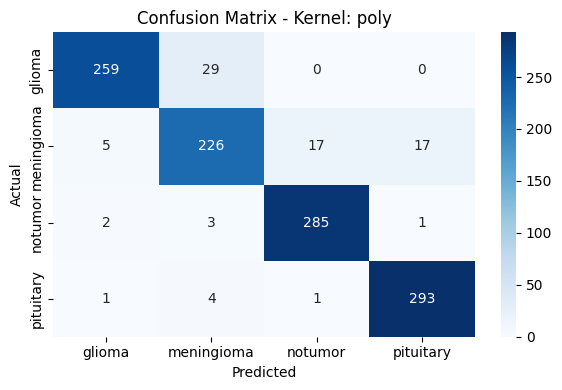

Computation Time: 4.89 seconds



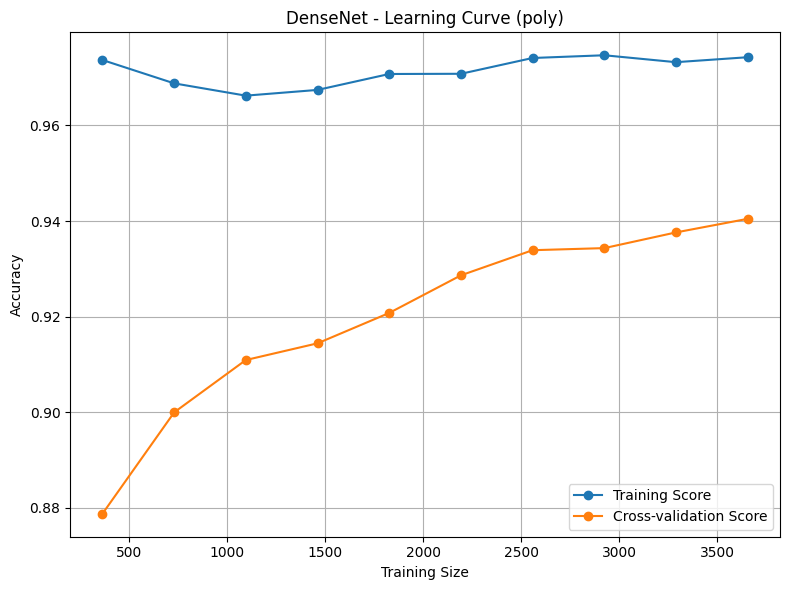

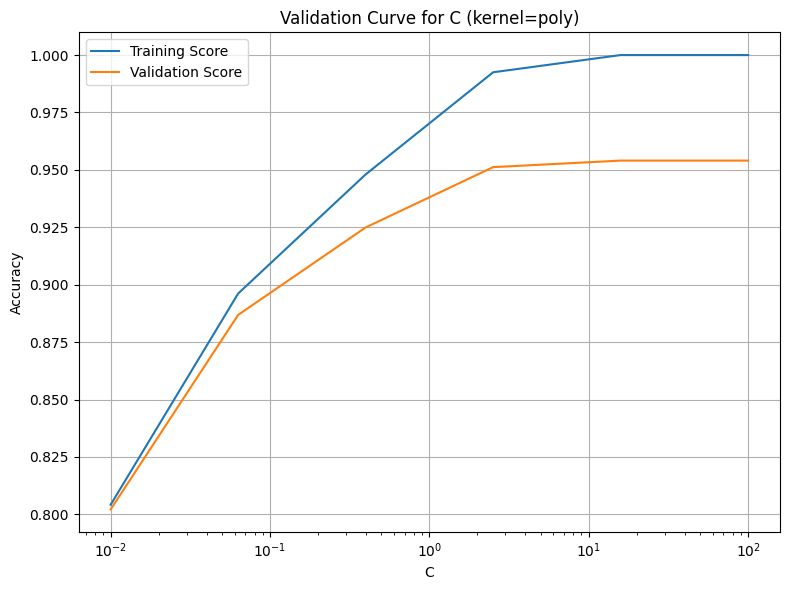


InceptionV3:
Training SVM with kernel: rbf

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.85      0.91       288
           1       0.82      0.86      0.84       265
           2       0.93      0.99      0.96       291
           3       0.94      0.96      0.95       299

    accuracy                           0.92      1143
   macro avg       0.92      0.92      0.92      1143
weighted avg       0.92      0.92      0.92      1143



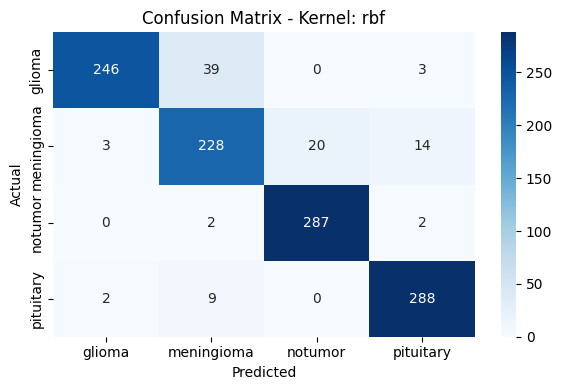

Computation Time: 14.21 seconds



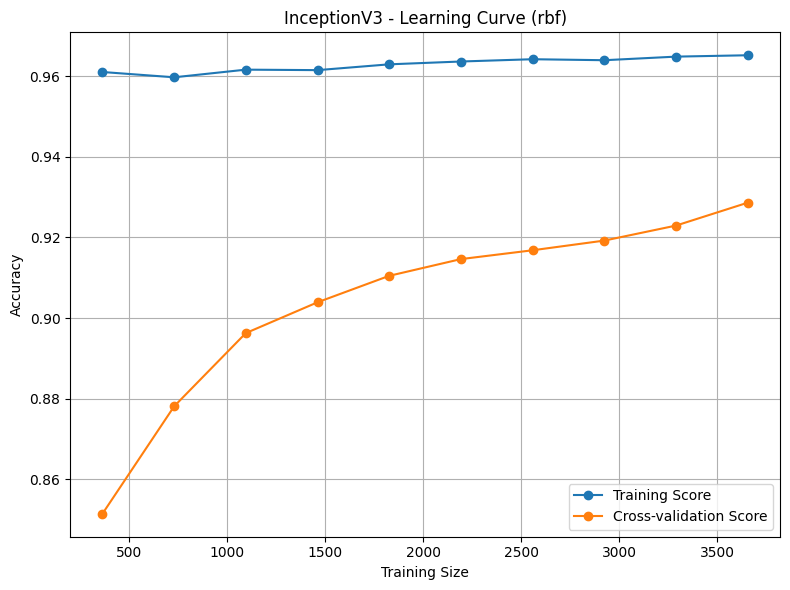

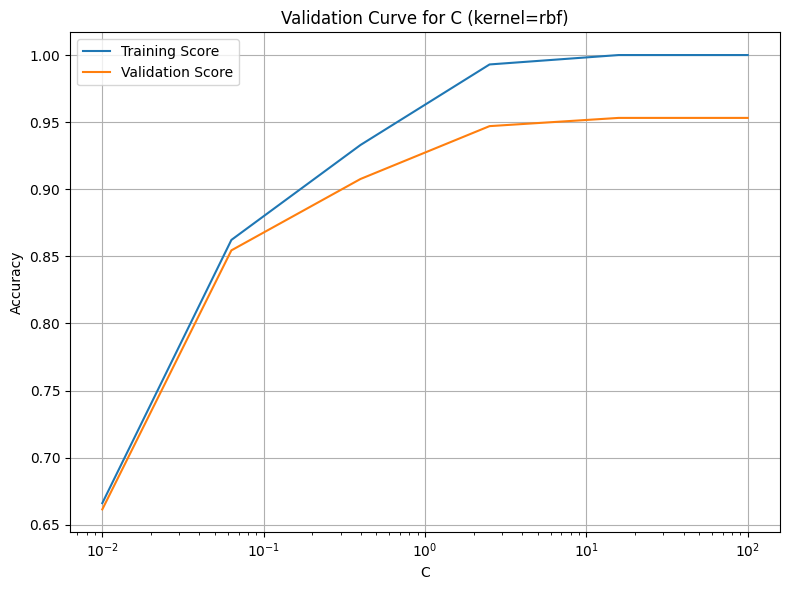

Training SVM with kernel: linear

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       288
           1       0.86      0.87      0.87       265
           2       0.94      0.98      0.96       291
           3       0.97      0.96      0.97       299

    accuracy                           0.93      1143
   macro avg       0.93      0.93      0.93      1143
weighted avg       0.93      0.93      0.93      1143



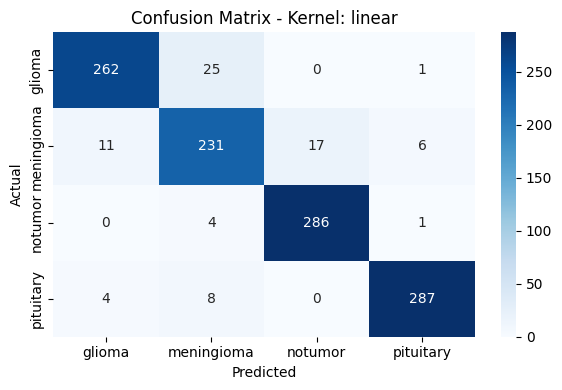

Computation Time: 8.38 seconds



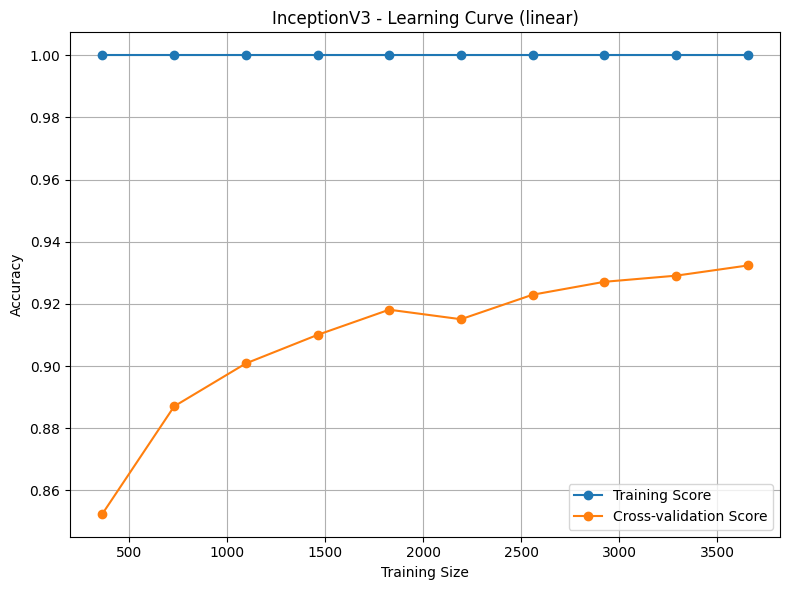

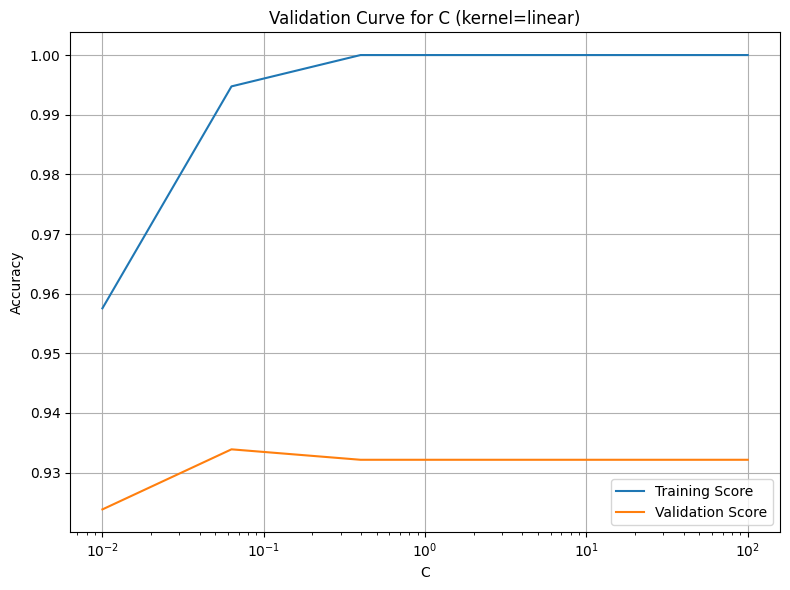

Training SVM with kernel: poly

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       288
           1       0.90      0.91      0.90       265
           2       0.96      0.99      0.97       291
           3       0.96      0.97      0.96       299

    accuracy                           0.95      1143
   macro avg       0.95      0.95      0.95      1143
weighted avg       0.95      0.95      0.95      1143



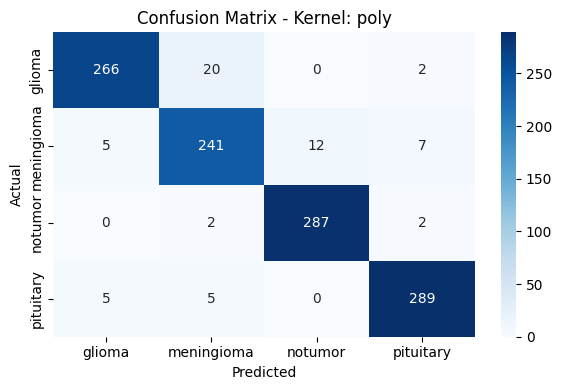

Computation Time: 10.63 seconds



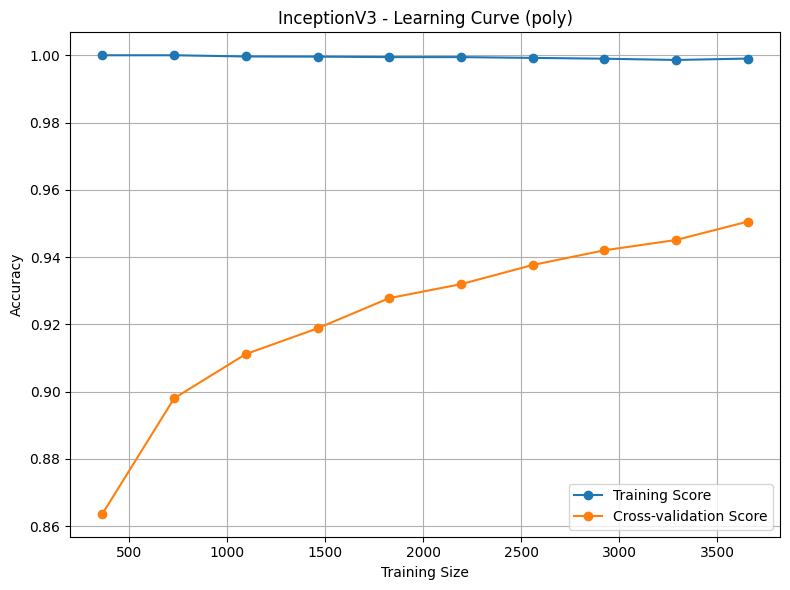

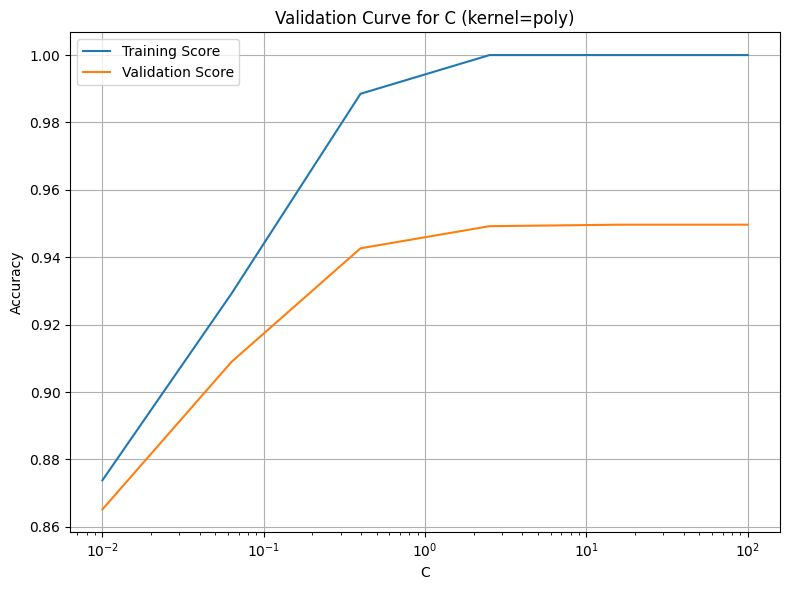


ResNet:
Training SVM with kernel: rbf

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.87      0.93       288
           1       0.83      0.86      0.85       265
           2       0.94      0.99      0.96       291
           3       0.94      0.96      0.95       299

    accuracy                           0.92      1143
   macro avg       0.92      0.92      0.92      1143
weighted avg       0.93      0.92      0.92      1143



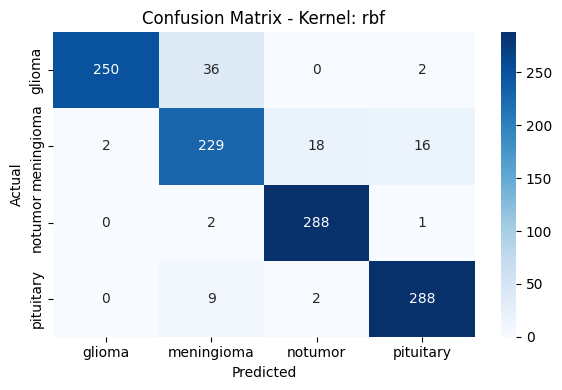

Computation Time: 11.60 seconds



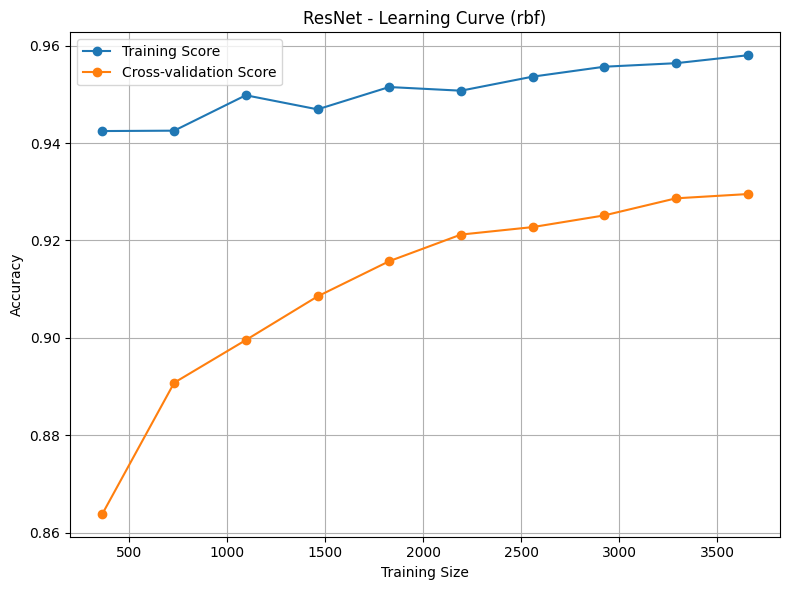

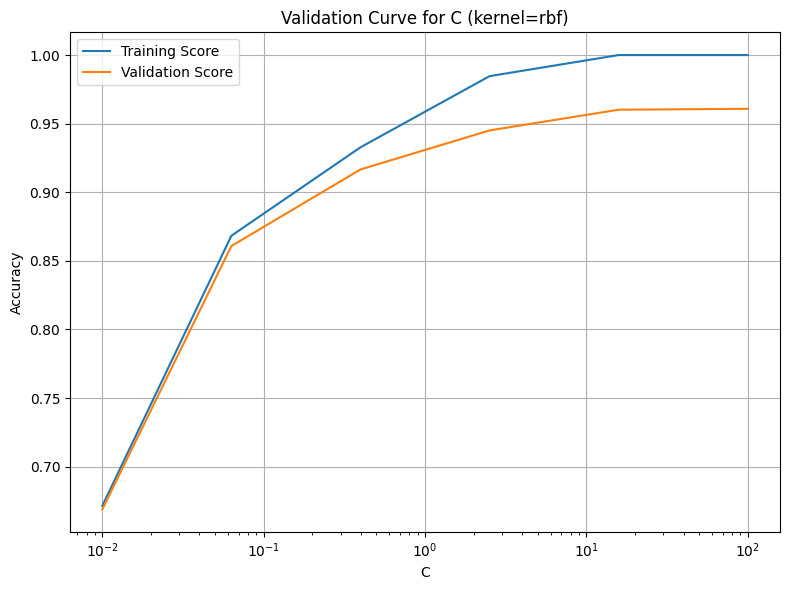

Training SVM with kernel: linear

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.92      0.94       288
           1       0.89      0.89      0.89       265
           2       0.94      0.99      0.96       291
           3       0.98      0.98      0.98       299

    accuracy                           0.95      1143
   macro avg       0.94      0.94      0.94      1143
weighted avg       0.95      0.95      0.95      1143



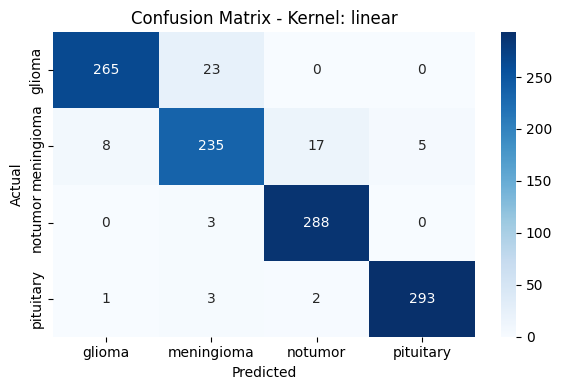

Computation Time: 6.99 seconds



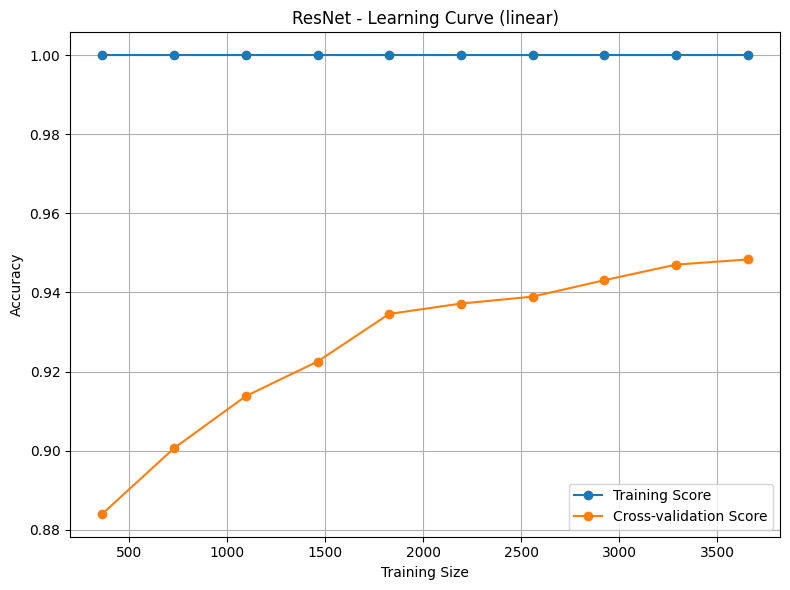

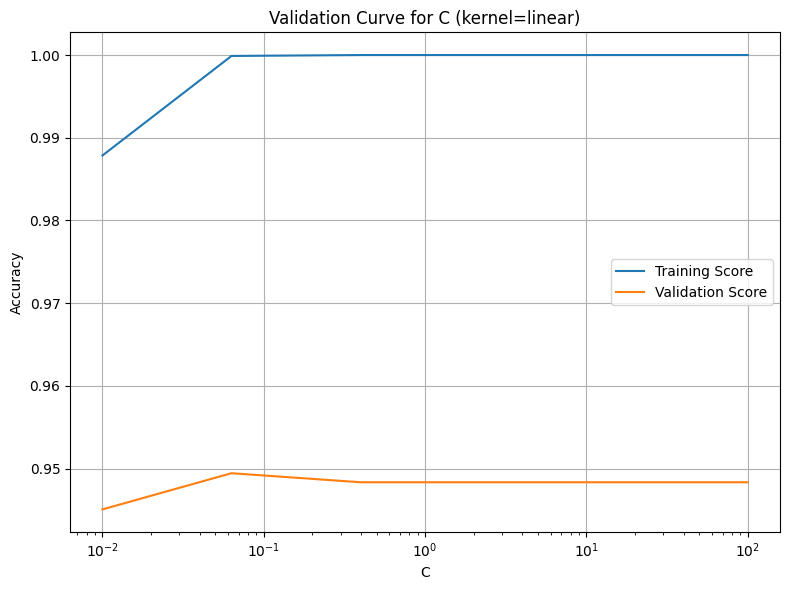

Training SVM with kernel: poly

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       288
           1       0.86      0.89      0.88       265
           2       0.94      0.99      0.97       291
           3       0.97      0.97      0.97       299

    accuracy                           0.94      1143
   macro avg       0.94      0.94      0.94      1143
weighted avg       0.94      0.94      0.94      1143



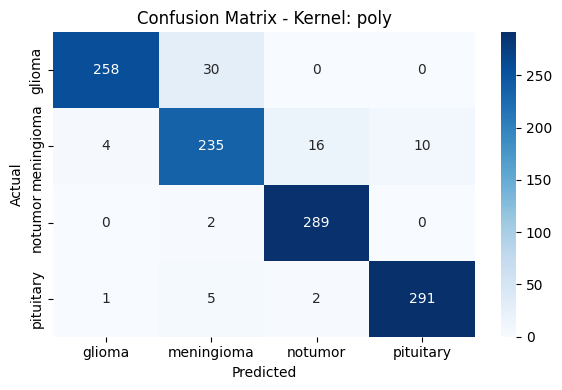

Computation Time: 8.85 seconds



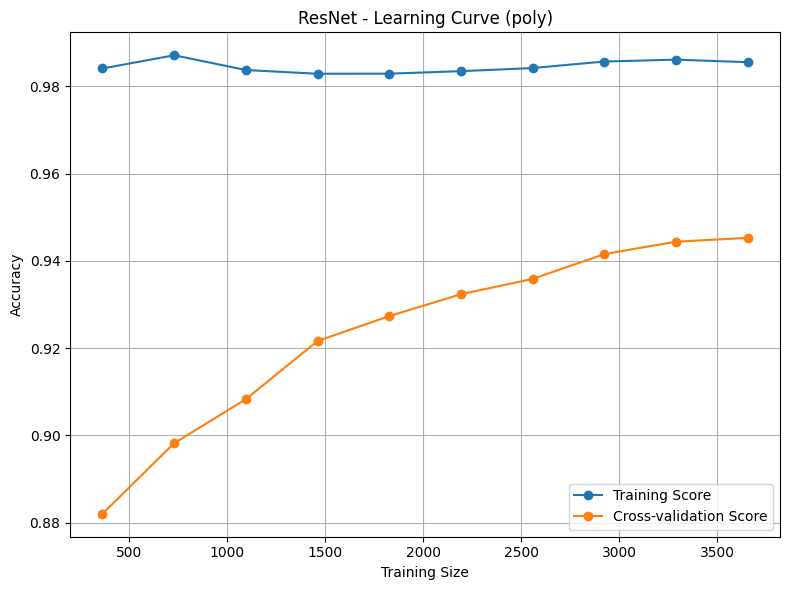

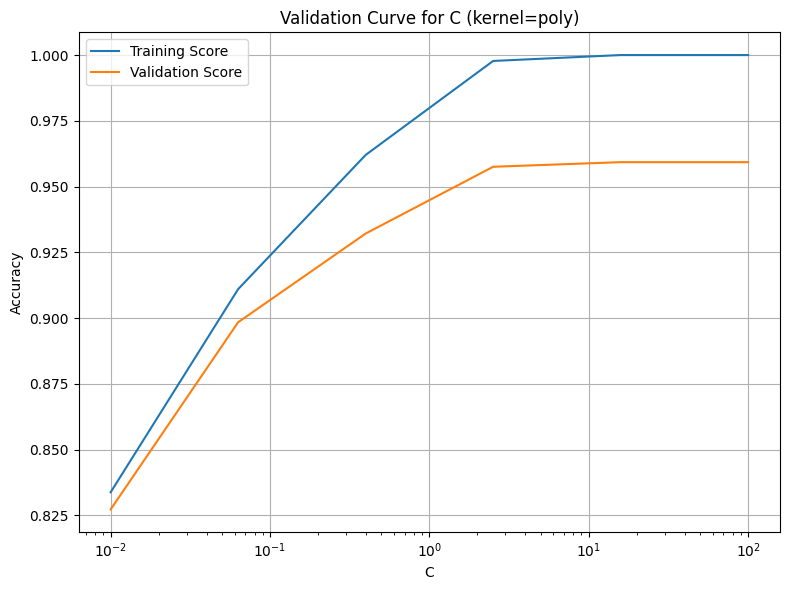

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import learning_curve, validation_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import pandas as pd

def train_and_evaluate_svm(X_train, X_test, y_train, y_test, kernel='rbf'):
    print(f"Training SVM with kernel: {kernel}")
    start_time = time.time()

    # Train the SVM
    model = SVC(kernel=kernel, random_state=42)
    model.fit(X_train, y_train)
    end_time = time.time()

    # Predictions
    y_pred = model.predict(X_test)

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    class_names = ['glioma','meningioma','notumor','pituitary']  # Modify if needed
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - Kernel: {kernel}')
    plt.tight_layout()
    plt.show()

    # Computation Time
    print(f"Computation Time: {end_time - start_time:.2f} seconds\n")

    return model


def plot_learning_curve(estimator, X, y, title='Learning Curve', cv=5):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y,
                                                            cv=cv,
                                                            train_sizes=np.linspace(0.1, 1.0, 10),
                                                            scoring='accuracy',
                                                            n_jobs=-1)

    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, 'o-', label='Training Score')
    plt.plot(train_sizes, test_mean, 'o-', label='Cross-validation Score')
    plt.title(title)
    plt.xlabel('Training Size')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()


def plot_validation_curve(X, y, param_name, param_range, kernel='rbf', cv=5):
    model = SVC(kernel=kernel, random_state=42)
    train_scores, test_scores = validation_curve(
        model, X, y, param_name=param_name, param_range=param_range,
        scoring='accuracy', cv=cv, n_jobs=-1
    )

    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(param_range, train_mean, label='Training Score')
    plt.plot(param_range, test_mean, label='Validation Score')
    plt.title(f'Validation Curve for {param_name} (kernel={kernel})')
    plt.xlabel(param_name)
    plt.ylabel('Accuracy')
    plt.xscale('log')  # Use log scale for C or gamma
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# ========== Run for each CNN feature set ==========

def full_svm_pipeline(X_train, X_test, y_train, y_test, feature_set_name):
    print(f"\n{feature_set_name}:")

    for kernel in ['rbf', 'linear', 'poly']:
        model = train_and_evaluate_svm(X_train, X_test, y_train, y_test, kernel=kernel)

        # Plot Learning Curve
        plot_learning_curve(model, X_train, y_train, title=f'{feature_set_name} - Learning Curve ({kernel})')

        # Plot Validation Curve for C
        param_range = np.logspace(-2, 2, 6)
        plot_validation_curve(X_train, y_train, param_name='C', param_range=param_range, kernel=kernel)

# Run all feature sets
full_svm_pipeline(X_train_densenet, X_test_densenet, y_train_densenet, y_test_densenet, "DenseNet")
full_svm_pipeline(X_train_inception, X_test_inception, y_train_inception, y_test_inception, "InceptionV3")
full_svm_pipeline(X_train_resnet, X_test_resnet, y_train_resnet, y_test_resnet, "ResNet")


In [ ]:
def train_and_evaluate_svm(X_train, X_test, y_train, y_test, kernel):
    print(f"Training SVM with kernel: {kernel}")
    start_time = time.time()
    model = SVC(kernel=kernel, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    end_time = time.time()
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size,
        callbacks=callbacks
    )
    history_df = pd.DataFrame(history.history)
    history_df.to_csv('training_history.csv', index=False)

    #history print plot
    # def plot_learning_curves(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig('learning_curves.png')
    plt.show()


    # # Classification Report
    # print(classification_report(y_test, y_pred))

    # # Confusion Matrix
    # class_name = ['glioma','meningioma','notumor','pituitary']
    # cm = confusion_matrix(y_test, y_pred)
    # plt.figure(figsize=(6, 4))
    # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_name , yticklabels=class_name)
    # plt.xlabel('Predicted')
    # plt.ylabel('Actual')
    # plt.title(f'Confusion Matrix - Kernel: {kernel}')
    # plt.show()

    # Computation Time
    print(f"Computation Time: {end_time - start_time:.2f} seconds\n")

    return model

# DenseNet
print("DenseNet:")
train_and_evaluate_svm(X_train_densenet, X_test_densenet, y_train_densenet, y_test_densenet, kernel='rbf')
train_and_evaluate_svm(X_train_densenet, X_test_densenet, y_train_densenet, y_test_densenet, kernel='linear')
train_and_evaluate_svm(X_train_densenet, X_test_densenet, y_train_densenet, y_test_densenet, kernel='poly')

# InceptionV3
print("\nInceptionV3:")
train_and_evaluate_svm(X_train_inception, X_test_inception, y_train_inception, y_test_inception, kernel='rbf')
train_and_evaluate_svm(X_train_inception, X_test_inception, y_train_inception, y_test_inception, kernel='linear')
train_and_evaluate_svm(X_train_inception, X_test_inception, y_train_inception, y_test_inception, kernel='poly')

# ResNet
print("\nResNet:")
train_and_evaluate_svm(X_train_resnet, X_test_resnet, y_train_resnet, y_test_resnet, kernel='rbf')
train_and_evaluate_svm(X_train_resnet, X_test_resnet, y_train_resnet, y_test_resnet, kernel='linear')
train_and_evaluate_svm(X_train_resnet, X_test_resnet, y_train_resnet, y_test_resnet, kernel='poly')

DenseNet:
Training SVM with kernel: rbf


NameError: name 'train_generator' is not defined

# Penggabungan Dataset

In [ ]:
# Gabungan DenseNet dan InceptionV3
df_densenet_inception = pd.concat(
    [df_densenet.drop(columns=['Label', 'EncodedLabel']),
     df_inception.drop(columns=['Label', 'EncodedLabel'])],
    axis=1
)
df_densenet_inception['Label'] = df_densenet['Label']  # Menyertakan kembali label

# Gabungan DenseNet dan ResNet
df_densenet_resnet = pd.concat(
    [df_densenet.drop(columns=['Label', 'EncodedLabel']),
     df_resnet.drop(columns=['Label', 'EncodedLabel'])],
    axis=1
)
df_densenet_resnet['Label'] = df_densenet['Label']  # Menyertakan kembali label

# Gabungan InceptionV3 dan ResNet
df_inception_resnet = pd.concat(
    [df_inception.drop(columns=['Label', 'EncodedLabel']),
     df_resnet.drop(columns=['Label', 'EncodedLabel'])],
    axis=1
)
df_inception_resnet['Label'] = df_inception['Label']  # Menyertakan kembali label


In [ ]:
df_combined = pd.concat(
    [df_densenet.drop(columns=['Label', 'EncodedLabel']),
     df_inception.drop(columns=['Label', 'EncodedLabel']),
     df_resnet.drop(columns=['Label', 'EncodedLabel'])],
    axis=1
)
df_combined['Label'] = df_densenet['Label']  # Menyertakan kembali label


In [ ]:
# Encode label untuk dataset gabungan
df_densenet_inception, le_densenet_inception = encode_labels(df_densenet_inception)
df_densenet_resnet, le_densenet_resnet = encode_labels(df_densenet_resnet)
df_inception_resnet, le_inception_resnet = encode_labels(df_inception_resnet)
df_combined, le_combined = encode_labels(df_combined)


In [ ]:
# Split data untuk masing-masing kombinasi
X_train_di, X_test_di, y_train_di, y_test_di = split_data(df_densenet_inception)
X_train_dr, X_test_dr, y_train_dr, y_test_dr = split_data(df_densenet_resnet)
X_train_ir, X_test_ir, y_train_ir, y_test_ir = split_data(df_inception_resnet)
X_train_combined, X_test_combined, y_train_combined, y_test_combined = split_data(df_combined)


In [ ]:
# DenseNet + InceptionV3
print("DenseNet + InceptionV3:")
train_and_evaluate_svm(X_train_di, X_test_di, y_train_di, y_test_di, kernel='rbf')
train_and_evaluate_svm(X_train_di, X_test_di, y_train_di, y_test_di, kernel='linear')
train_and_evaluate_svm(X_train_di, X_test_di, y_train_di, y_test_di, kernel='poly')

# DenseNet + ResNet
print("\nDenseNet + ResNet:")
train_and_evaluate_svm(X_train_dr, X_test_dr, y_train_dr, y_test_dr, kernel='rbf')
train_and_evaluate_svm(X_train_dr, X_test_dr, y_train_dr, y_test_dr, kernel='linear')
train_and_evaluate_svm(X_train_dr, X_test_dr, y_train_dr, y_test_dr, kernel='poly')

# InceptionV3 + ResNet
print("\nInceptionV3 + ResNet:")
train_and_evaluate_svm(X_train_ir, X_test_ir, y_train_ir, y_test_ir, kernel='rbf')
train_and_evaluate_svm(X_train_ir, X_test_ir, y_train_ir, y_test_ir, kernel='linear')
train_and_evaluate_svm(X_train_ir, X_test_ir, y_train_ir, y_test_ir, kernel='poly')

# Combined Dataset (DenseNet + InceptionV3 + ResNet)
print("\nCombined Dataset:")
train_and_evaluate_svm(X_train_combined, X_test_combined, y_train_combined, y_test_combined, kernel='rbf')
train_and_evaluate_svm(X_train_combined, X_test_combined, y_train_combined, y_test_combined, kernel='linear')
train_and_evaluate_svm(X_train_combined, X_test_combined, y_train_combined, y_test_combined, kernel='poly')


# PCA

In [ ]:
from sklearn.decomposition import PCA


In [ ]:
def apply_pca(X, n_components):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    print(f"Original Shape: {X.shape}, Reduced Shape: {X_pca.shape}")
    return X_pca, pca


In [ ]:
# DenseNet + InceptionV3
X_train_di_pca, pca_di = apply_pca(X_train_di, n_components=12)  # Reduce to 50 components
X_test_di_pca = pca_di.transform(X_test_di)

# DenseNet + ResNet
X_train_dr_pca, pca_dr = apply_pca(X_train_dr, n_components=12)
X_test_dr_pca = pca_dr.transform(X_test_dr)

# InceptionV3 + ResNet
X_train_ir_pca, pca_ir = apply_pca(X_train_ir, n_components=12)
X_test_ir_pca = pca_ir.transform(X_test_ir)

# Combined Dataset (DenseNet + InceptionV3 + ResNet)
X_train_combined_pca, pca_combined = apply_pca(X_train_combined, n_components=24)
X_test_combined_pca = pca_combined.transform(X_test_combined)


In [ ]:
# Fungsi untuk memplot korelasi antar fitur pada dataset PCA
def plot_pca_correlation_heatmap(X_pca, title):
    # Pastikan dataset dalam bentuk DataFrame
    X_pca_df = pd.DataFrame(X_pca)

    # Hitung korelasi
    correlation_matrix = X_pca_df.corr()

    # Plot heatmap korelasi
    plt.figure(figsize=(10, 8))  # Sesuaikan ukuran
    plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto')
    plt.colorbar()
    plt.title(f"Feature Correlation Heatmap - {title}")
    plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90, fontsize=8)
    plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, fontsize=8)
    plt.tight_layout()
    plt.show()

# Plot korelasi untuk masing-masing dataset PCA
print("Korelasi Antar Fitur Sebelum Evaluasi SVM:\n")
plot_pca_correlation_heatmap(X_train_di_pca, "DenseNet + InceptionV3 PCA")
plot_pca_correlation_heatmap(X_train_dr_pca, "DenseNet + ResNet PCA")
plot_pca_correlation_heatmap(X_train_ir_pca, "InceptionV3 + ResNet PCA")
plot_pca_correlation_heatmap(X_train_combined_pca, "Combined Dataset PCA")

In [ ]:
# DenseNet + InceptionV3 with PCA
print("DenseNet + InceptionV3 with PCA:")
train_and_evaluate_svm(X_train_di_pca, X_test_di_pca, y_train_di, y_test_di, kernel='rbf')
train_and_evaluate_svm(X_train_di_pca, X_test_di_pca, y_train_di, y_test_di, kernel='linear')
train_and_evaluate_svm(X_train_di_pca, X_test_di_pca, y_train_di, y_test_di, kernel='poly')

# DenseNet + ResNet with PCA
print("\nDenseNet + ResNet with PCA:")
train_and_evaluate_svm(X_train_dr_pca, X_test_dr_pca, y_train_dr, y_test_dr, kernel='rbf')
train_and_evaluate_svm(X_train_dr_pca, X_test_dr_pca, y_train_dr, y_test_dr, kernel='linear')
train_and_evaluate_svm(X_train_dr_pca, X_test_dr_pca, y_train_dr, y_test_dr, kernel='poly')

# InceptionV3 + ResNet with PCA
print("\nInceptionV3 + ResNet with PCA:")
train_and_evaluate_svm(X_train_ir_pca, X_test_ir_pca, y_train_ir, y_test_ir, kernel='rbf')
train_and_evaluate_svm(X_train_ir_pca, X_test_ir_pca, y_train_ir, y_test_ir, kernel='linear')
train_and_evaluate_svm(X_train_ir_pca, X_test_ir_pca, y_train_ir, y_test_ir, kernel='poly')

# Combined Dataset with PCA
print("\nCombined Dataset with PCA:")
train_and_evaluate_svm(X_train_combined_pca, X_test_combined_pca, y_train_combined, y_test_combined, kernel='rbf')
train_and_evaluate_svm(X_train_combined_pca, X_test_combined_pca, y_train_combined, y_test_combined, kernel='linear')
train_and_evaluate_svm(X_train_combined_pca, X_test_combined_pca, y_train_combined, y_test_combined, kernel='poly')


In [ ]:
print("Explained Variance Ratio (DenseNet + Inception):", pca_di.explained_variance_ratio_)
print("Explained Variance Ratio (DenseNet + ResNet):", pca_dr.explained_variance_ratio_)
print("Explained Variance Ratio (InceptionV3 + ResNet):", pca_ir.explained_variance_ratio_)
print("Explained Variance Ratio (Combined):", pca_combined.explained_variance_ratio_)